In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import ase
from ase.io import read,write
from ase.visualize import view
import sys,os
from glob import glob
from copy import copy
from tqdm import tqdm_notebook
import cPickle as pck

In [3]:
sys.path.insert(0,'/local/git/ml_tools/')

In [4]:
import quippy as qp

In [5]:
import sh

In [6]:
import spglib as spg

In [7]:
def get_sp_mapping(frames,sp):
    ii = 0
    fid2gids = {it:[] for it in range(len(frames))}
    for iframe,cc in enumerate(frames):
        for ss in cc.get_atomic_numbers():
            if ss == sp:
                fid2gids[iframe].append(ii)
                ii += 1
    return fid2gids


In [8]:
from ml_tools.descriptors.quippy_interface import RawSoapQUIP
from ml_tools.models.KRR import KRR,TrainerCholesky,KRRFastCV
from ml_tools.models.pipelines import RegressorPipeline
from ml_tools.models.handlers import HashJsonHandler
from ml_tools.kernels.kernels import KernelPower,KernelSparseSoR
from ml_tools.io_utils import load_pck
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score
from ml_tools.split.spliter import KFold,EnvironmentalKFold,LCSplit,ShuffleSplit,EnvironmentalShuffleSplit
from ml_tools.model_selection.scorer import CrossValidationScorer
from ml_tools.model_selection.gs import GridSearch
from ml_tools.base import KernelBase,BaseEstimator,TransformerMixin
from ml_tools.math_utils.optimized import power
from ml_tools.compressor.fps import FPSFilter
from ml_tools.compressor.filter import SymmetryFilter

# train and predict

In [22]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':10')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [23]:
delta = np.std(y)
zeta = 2
jitter = 1e-8

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,trainer)

In [24]:
rawsoaps = representation.transform(frames_train)
kk = kernel.transform(rawsoaps)
krr.fit(kk,y_train)

In [25]:
frames_test = read(fn,index='10:20')
prop = []
for cc in frames_test:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_true = np.array(prop)

In [27]:
rawsoaps_test = representation.transform(frames_test)
kk_test = kernel.transform(rawsoaps_test,X_train=rawsoaps)
y_pred = krr.predict(kk_test)
get_score(y_pred,y_true)

(1.8079299206273776,
 2.4277177081353867,
 7.322334419945037,
 0.4631398849450846,
 0.7504786883833238)

# FPS selection of the samples

In [10]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':10')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [12]:
delta = np.std(y_train)
zeta = 2
Nselect = 6

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)

In [16]:
rawsoaps = representation.transform(frames_train)
rawsoaps.shape

(650, 11761)

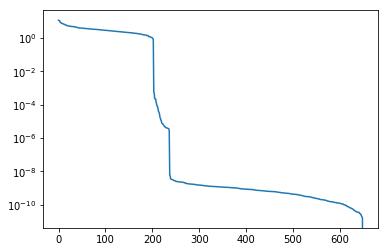

In [15]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [17]:
Nselect = 250
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
compressor.fit(rawsoaps)

FPSFilter(Nselect=250, act_on='sample',
     kernel=KernelPower(delta=3.222900421236607, zeta=2))

# Filter equivalent atoms

In [32]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [33]:
delta = np.std(y_train)
zeta = 2

soap_params = dict(rc=5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)
representation = RawSoapQUIP(**soap_params)

In [19]:
rawsoaps = representation.transform(frames_train)

In [22]:
filt = SymmetryFilter(threshold=1e-4,species=[sp])
X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
print X_filt.shape,filt.strides[-1]
print len(filt.filter_ids_inv)
a,b = filt.inverse_transform(X_filt,y_filt)
print np.allclose(rawsoaps,a,atol=1e-4),np.allclose(y_train,b,atol=1e-4)



(7543, 11761) 7543
17857
True False


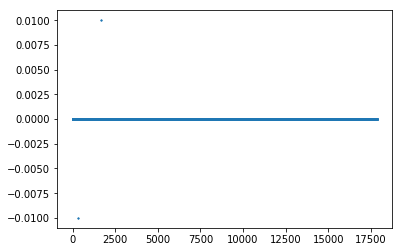

In [21]:
plt.plot(y_train-b,'o',ms=1)

# CV

In [77]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':100')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [81]:
delta = np.std(y)*0.01
zeta = 2
jitter = 1e-8

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)


cv = EnvironmentalKFold(n_splits=6,random_state=10,shuffle=True,mapping=mapping)
krr = KRRFastCV(jitter,cv)

In [82]:
rawsoaps = representation.transform(frames)

In [83]:
Kmat = kernel.transform(rawsoaps)
krr.fit(Kmat,y)
y_pred = krr.predict()
get_score(y_pred,y)

(0.6573786013644255,
 0.9200334849108767,
 6.423142269994784,
 0.911647617988212,
 0.951666531617626)

## test with sparse kernel

### ref

In [85]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':100')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [86]:
delta = np.std(y)*0.01
zeta = 2
jitter = 1e-8
Nselect = 10

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kern = KernelPower(zeta,delta)
kernel = KernelSparseSoR(kern)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kern,act_on='sample',precompute_kernel=True,disable_pbar=True)
filt = SymmetryFilter(threshold=1e-4,species=[sp])

cv = EnvironmentalKFold(n_splits=6,random_state=10,shuffle=True,mapping=mapping)
krr = KRR(jitter,trainer)

In [87]:
rawsoaps = representation.transform(frames)

In [88]:
X_filt, y_filt = filt.fit_transform(dict(frames=frames,feature_matrix=rawsoaps),y=y)

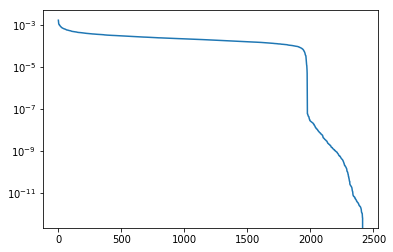

In [89]:
compressor.fit(X_filt,dry_run=True)
compressor.plot()

In [91]:
X_pseudo = rawsoaps[compressor.selected_ids[:1000]]
scores = []
error = []
for train,test in cv.split(rawsoaps):
    Ktrain,ytrain = kernel.transform(X=rawsoaps[train],y=y[train],X_pseudo=X_pseudo) 
    Ktest = kernel.transform(X=rawsoaps[test],X_train=X_pseudo) 
    krr.fit(Ktrain,ytrain)
    y_pred = krr.predict(Ktest)
    error.extend(y_pred-y[test])
    scores.append(get_score(y_pred,y[test]))
#score = (np.mean(np.abs(error)),np.sqrt(np.mean(np.square(error))))
score = np.mean(scores,axis=0)
print score

[0.92307202 1.26436442 5.68397433 0.80199702 0.90468017]


### test fast

In [103]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':100')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [104]:
delta = np.std(y)*0.01
zeta = 2
jitter = 1e-8
Nselect = 10

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kern = KernelPower(zeta,delta)
kernel = KernelSparseSoR(kern)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kern,act_on='sample',precompute_kernel=True,disable_pbar=True)
filt = SymmetryFilter(threshold=1e-4,species=[sp])

cv = KFold(n_splits=6,random_state=10,shuffle=True)
krr = KRR(jitter,trainer)

In [105]:
rawsoaps = representation.transform(frames)

In [106]:
X_filt, y_filt = filt.fit_transform(dict(frames=frames,feature_matrix=rawsoaps),y=y)

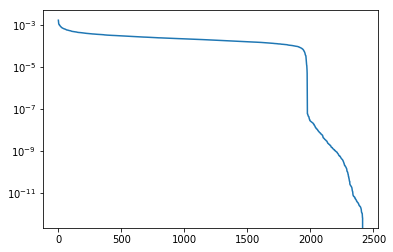

In [107]:
compressor.fit(X_filt,dry_run=True)
compressor.plot()

In [108]:
X_pseudo = rawsoaps[compressor.selected_ids[:1000]]

In [110]:

spK,spY = kernel.transform(X=rawsoaps,y=y,X_pseudo=X_pseudo) 
kMN_inv = np.linalg.pinv(kernel.kernel(X_pseudo,Y=rawsoaps))

Q_inv = np.linalg.inv(spK)
alpha = np.dot(Q_inv,spY)
Cii = []
beta = np.zeros(alpha.shape)
y_pred = np.zeros(y.shape)
error = np.zeros(y.shape)
for _,test in cv.split(spK):
    Cii = Q_inv[np.ix_(test,test)]
    beta[test] = np.linalg.solve(Cii,alpha[test]) 
error = np.dot(kMN_inv,beta) # beta = y_true - y_pred 
y_pred = y - error
scores.append(get_score(y_pred,y))
#score = (np.mean(np.abs(error)),np.sqrt(np.mean(np.square(error))))
score = np.mean(scores,axis=0)
print score

[9.14823797e+07 1.18827264e+08 6.26699926e+08 6.87426007e-01
 7.73560571e-01]


In [113]:
beta.shape

(1000,)

# LC

In [8]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':20')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [9]:
delta = np.std(y)
zeta = 2
jitter = 1e-8

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,trainer)


In [10]:
rawsoaps = representation.transform(frames)
K = kernel.transform(rawsoaps)

In [11]:
lc = LCSplit(EnvironmentalShuffleSplit, n_repeats=[5,5],train_sizes=[5,10],test_size=10, random_state=10,mapping=mapping)


In [12]:
score = []
for train,test in tqdm_notebook(lc.split(rawsoaps),total=lc.n_splits):
    k_train = K[np.ix_(train,train)]
    y_train = y[train]
    k_test = K[np.ix_(test,train)]
    krr.fit(k_train,y_train)
    y_pred = krr.predict(k_test)
    score.append(get_score(y_pred,y[test]))

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

In [15]:
35000**2*8/1e9

9.8

# Procedure of the paper (updated)

## detect outlier in the train set

In [49]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)


In [50]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])


In [51]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [52]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [91]:
np.random.seed(10)
seeds = np.random.randint(low=0,high=1000,size=(100,))
preds = []
for seed in tqdm_notebook(seeds):
    cv = EnvironmentalKFold(n_splits=3,random_state=seed,shuffle=True,mapping=mapping)
    krr = KRRFastCV(jitter,cv)
    
    krr.fit(Kmat,y_filt)
    
    yp_filt = krr.predict()
    _,y_pred = filt.inverse_transform(y=yp_filt)
    preds.append(y_pred)
preds = np.array(preds)

HBox(children=(IntProgress(value=0), HTML(value=u'')))

In [92]:
m = np.mean(preds-y_train,axis=0)
s = np.std(preds-y_train,axis=0)

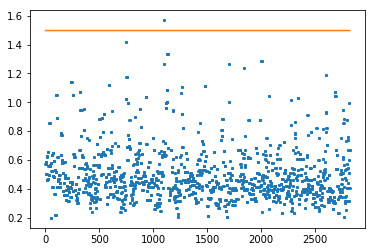

In [93]:
plt.plot(s,'o',ms=2,)
plt.plot(3*s.mean()*np.ones(len(m)),'-',ms=2,)

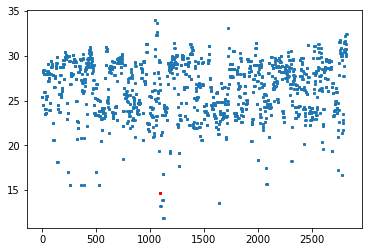

In [94]:
plt.plot(y_train,'o',ms=2)
plt.plot(np.where(s>3*s.mean())[0],y_train[s>3*s.mean()],'ro',ms=2,)

In [95]:
mapping_sp = get_sp_mapping(frames_train,sp)

iii = np.where(s>3*s.mean())[0]
suspicious_center = iii
sp,name=1,'ccsd'
suspicious_frame = []
for icenter in iii:
    for iframe,centers in mapping_sp.iteritems():
        if icenter in centers:
            suspicious_frame.append(iframe)
            break

#print np.unique(suspicious_frame)
suspicious_frame = np.unique(suspicious_frame)
suspicious_frame

array([18])

## FPS filtering

In [112]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [113]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

49


In [114]:
delta = np.std(y_train)
zeta = 2
Nselect = 6

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
filt = SymmetryFilter(threshold=1e-4,species=[sp])

In [115]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)


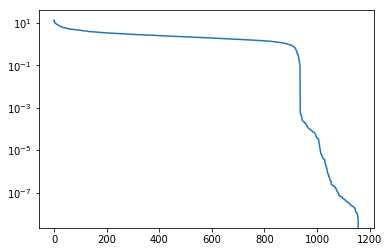

In [116]:
compressor.fit(X_filt,dry_run=True)
compressor.plot()

## CV score for a model

In [100]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [101]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

49


In [102]:
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [107]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8
Nselect = 1000

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)



In [108]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [109]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [110]:

cv = EnvironmentalKFold(n_splits=10,random_state=seed,shuffle=True,mapping=mapping)
krr = KRRFastCV(jitter,cv)

In [111]:

krr.fit(Kmat,y_filt)

yp_filt = krr.predict()
_,y_pred = filt.inverse_transform(y=yp_filt)

get_score(y_train,y_pred)

(0.7476413086559425,
 0.9923627295631735,
 6.964805883089406,
 0.902222396797154,
 0.9456986647400127)